# Configurações iniciais

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
from keras.utils import to_categorical, Sequence
from glob import glob
import matplotlib.image as img
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import Counter
import pandas as pd
from PIL import Image
import json
import base64
import random
import seaborn as sns

In [26]:
def get_img(caminho):
    return [img.imread(caminho) / 255, to_categorical(int(caminho.split('/')[-2]), 14)]

In [27]:
to_categorical(1, 14)

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [28]:
# Caminho para a pasta de imagens
image_folder = '/content/drive/MyDrive/images/'

In [29]:
caminho = '/content/drive/MyDrive/keypoints.json'
with open(caminho, 'r') as f:
    JSON = json.load(f)

# Análise exploratória


## Analisando Json

In [30]:
print(JSON['images']['1'])

2007_000063.jpg


In [31]:
print(JSON['annotations'][0])
print(JSON['annotations'][0]['image_id'])
print(JSON['annotations'][0]['bbox'])
print(JSON['annotations'][0]['keypoints'])
print(JSON['annotations'][0]['num_keypoints'])
print(JSON['annotations'][0]['category_id'])

{'image_id': 1, 'bbox': [123, 115, 379, 275], 'keypoints': [[193, 216, 1], [160, 217, 1], [174, 261, 1], [204, 186, 1], [152, 182, 1], [0, 0, 0], [0, 0, 0], [273, 168, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [266, 225, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [190, 145, 1], [351, 238, 1]], 'num_keypoints': 20, 'category_id': 1}
1
[123, 115, 379, 275]
[[193, 216, 1], [160, 217, 1], [174, 261, 1], [204, 186, 1], [152, 182, 1], [0, 0, 0], [0, 0, 0], [273, 168, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [266, 225, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [190, 145, 1], [351, 238, 1]]
20
1


In [32]:
print(JSON['categories'])
print(JSON['categories'][0]['name'])
print(JSON['categories'][1]['name'])
print(JSON['categories'][2]['name'])
print(JSON['categories'][3]['name'])
print(JSON['categories'][4]['name'])

[{'supercategory': 'animal', 'id': 1, 'name': 'dog', 'keypoints': ['left_eye', 'right_eye', 'nose', 'left_ear', 'right_ear', 'left_front_elbow', 'right_front_elbow', 'left_back_elbow', 'right_back_elbow', 'left_front_knee', 'right_front_knee', 'left_back_knee', 'right_back_knee', 'left_front_paw', 'right_front_paw', 'left_back_paw', 'right_back_paw', 'throat', 'withers', 'tailbase'], 'skeleton': [[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 17], [18, 19], [5, 9], [6, 10], [7, 11], [8, 12], [9, 13], [10, 14], [11, 15], [12, 16]]}, {'supercategory': 'animal', 'id': 2, 'name': 'cat', 'keypoints': ['left_eye', 'right_eye', 'nose', 'left_ear', 'right_ear', 'left_front_elbow', 'right_front_elbow', 'left_back_elbow', 'right_back_elbow', 'left_front_knee', 'right_front_knee', 'left_back_knee', 'right_back_knee', 'left_front_paw', 'right_front_paw', 'left_back_paw', 'right_back_paw', 'throat', 'withers', 'tailbase'], 'skeleton': [[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 17], [18, 19], [5, 9],

In [33]:
print(JSON['info'])

{'description': 'Animal Pose dataset from ICCV 2021 paper Cross-Domain Adaptation for Animal Pose Estimation', 'url': 'https://sites.google.com/view/animal-pose/', 'github': 'https://github.com/noahcao/animal-pose-dataset.git', 'contributor': 'Jinkun Cao, Hongyang Tang and Tencent Youtu X lab team', 'date_updated': '2021/7/14', 'resource': 'some images come from PASCAL VOC2011 dataset, whose are named as $year_$index.jpg, the other images are from public online resources'}


## Testando imagens

In [34]:
PATH = '/content/drive/MyDrive/images/' + JSON['images']['1']
print(PATH)

/content/drive/MyDrive/images/2007_000063.jpg


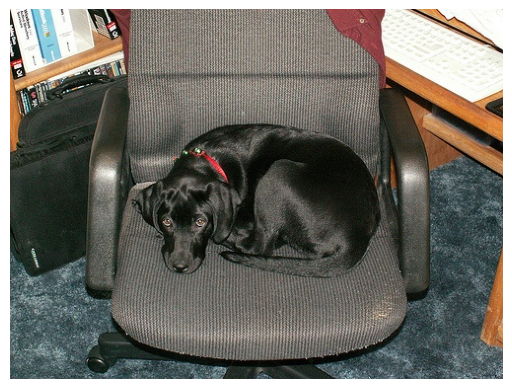

In [35]:
imagem = Image.open(PATH)

plt.imshow(imagem)
plt.axis('off')
plt.show()

## Plotando as imagens com os keypoints

nesta seção, vasculhamos todos os possiveis labels e aplicamos os keypoints em cada imagem.

In [36]:
def plt_img(image_path, bbox=None, keypoints=None):
    image = Image.open(image_path)
    plt.imshow(image)
    if bbox:
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
        plt.gca().add_patch(rect)
    if keypoints:
        for (x, y, v) in keypoints:
            if v > 0:
                plt.plot(x, y, 'bo')
    plt.axis('off')
    plt.show()

Exibindo a primeira imagem para category_id 1: 1.jpg


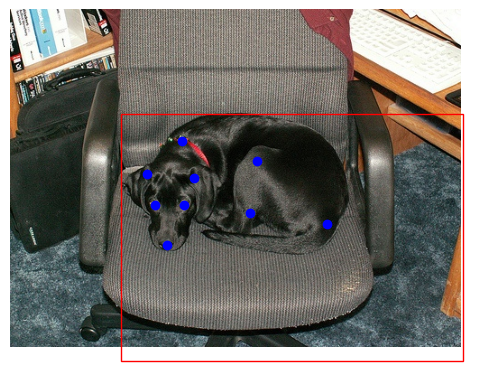

Exibindo a primeira imagem para category_id 2: 8.jpg


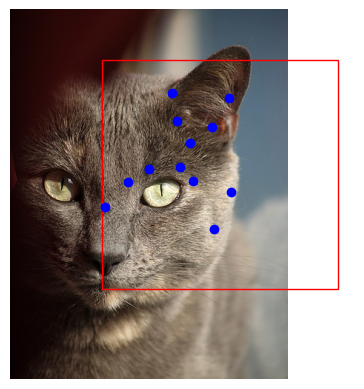

Exibindo a primeira imagem para category_id 3: 2.jpg


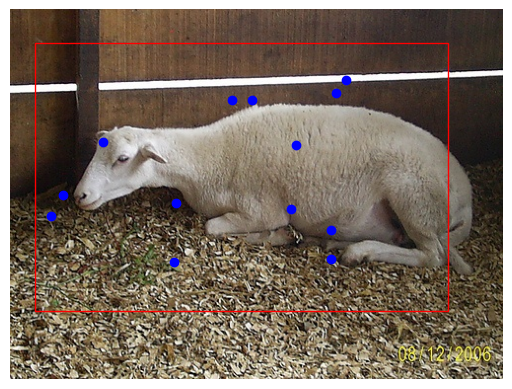

Exibindo a primeira imagem para category_id 4: 3.jpg


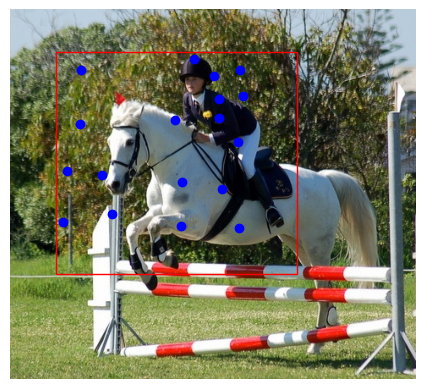

Exibindo a primeira imagem para category_id 5: 5.jpg


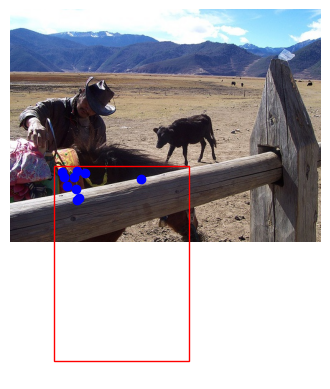

In [37]:
categorys = set(ann['category_id'] for ann in JSON['annotations'])

i = 1

for id in categorys:
    for annotation in JSON['annotations']:
        if annotation['category_id'] == id:
            image_id = annotation['image_id']
            image_filename = f"{image_id}.jpg"
            image_path = image_folder + JSON['images'][str(i)]
            print(f"Exibindo a primeira imagem para category_id {id}: {image_filename}")
            bbox = annotation.get('bbox', None)
            keypoints = annotation.get('keypoints', None)
            plt_img(image_path, bbox, keypoints)
            break
        i = i + 1


Após esta análise, podemos observar os animais presentes em cada imagem e seus respectivos Ids
- 1: Cachorro;
- 2: Gato;
- 3: Ovelha;
- 4: Cavalo;
- 5: Vaca.

## Criando lista com todas as vacas e mostrando 6 casos aleatórios

Exibindo a imagem /content/drive/MyDrive/images/2010_004456.jpg para category_id 5


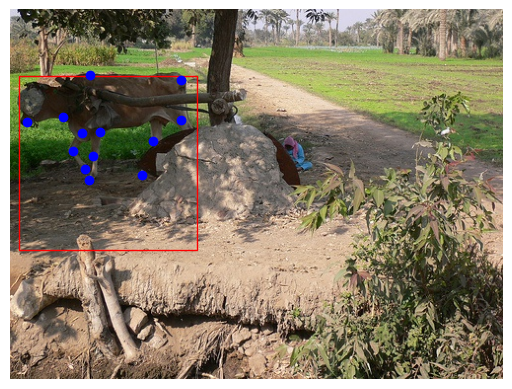

Exibindo a imagem /content/drive/MyDrive/images/2008_008241.jpg para category_id 5


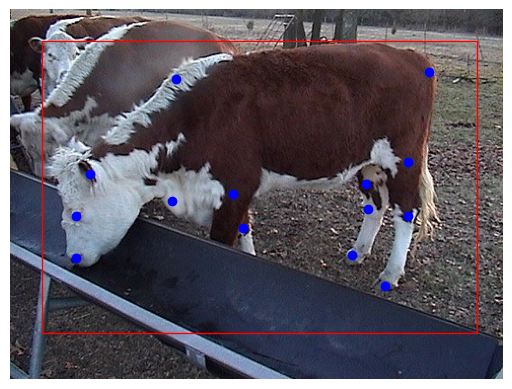

Exibindo a imagem /content/drive/MyDrive/images/2011_002609.jpg para category_id 5


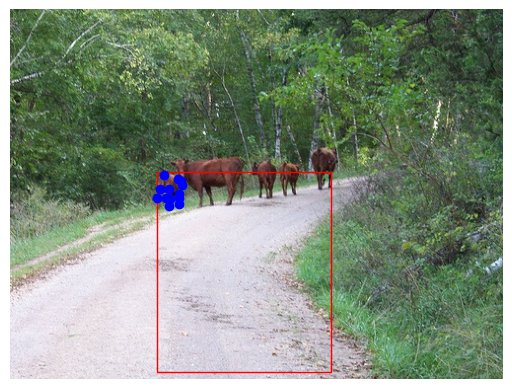

Exibindo a imagem /content/drive/MyDrive/images/2010_003383.jpg para category_id 5


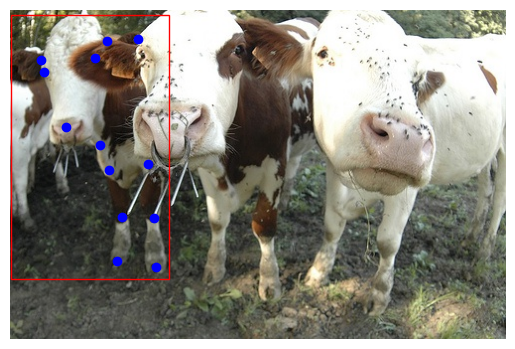

Exibindo a imagem /content/drive/MyDrive/images/co176.jpeg para category_id 5


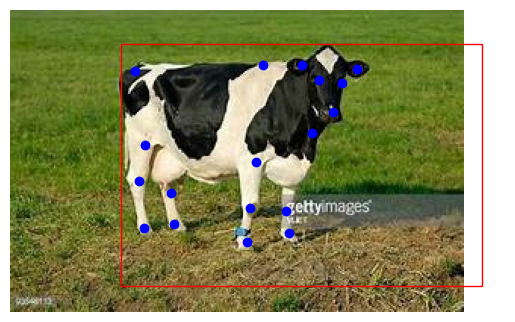

Exibindo a imagem /content/drive/MyDrive/images/2009_003189.jpg para category_id 5


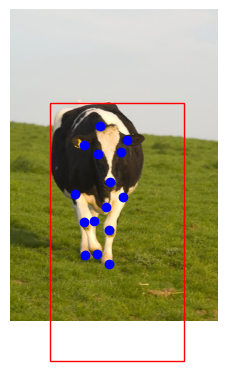

In [38]:
annotations = [ann for ann in JSON['annotations'] if ann['category_id'] == 5]

cows_data = {
    'images': JSON['images'],
    'annotations': annotations,
    'categories': JSON['categories']
}

cows_sample = random.sample(annotations, 6)

for annotation in cows_sample:
    image_id = annotation['image_id']
    image_path = image_folder + cows_data['images'][str(image_id)]
    print(f"Exibindo a imagem {image_path} para category_id 5")
    bbox = annotation.get('bbox', None)
    keypoints = annotation.get('keypoints', None)
    plt_img(image_path, bbox, keypoints)

# Análise estatistica

In [39]:
keypoints_count = {}
annotations_count = {}

for annotation in JSON['annotations']:
    category_id = annotation['category_id']
    num_keypoints = annotation['num_keypoints']

    keypoints_count[category_id] = keypoints_count.get(category_id, 0) + num_keypoints
    annotations_count[category_id] = annotations_count.get(category_id, 0) + 1

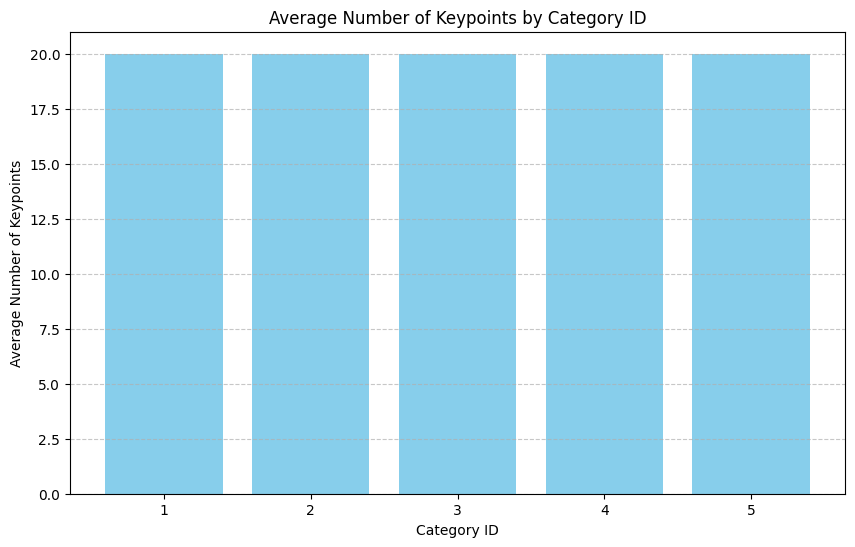

In [40]:
average_keypoints = {category_id: keypoints_count[category_id] / annotations_count[category_id] for category_id in keypoints_count}

plt.figure(figsize=(10, 6))
plt.bar(average_keypoints.keys(), average_keypoints.values(), color='skyblue')
plt.xlabel('Category ID')
plt.ylabel('Average Number of Keypoints')
plt.title('Average Number of Keypoints by Category ID')
plt.xticks(list(average_keypoints.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [41]:
num_dogs = 0
num_cats = 0
num_sheep = 0
num_horses = 0
num_cows = 0

In [42]:
# Itera sobre as anotações e conta os tipos de animais
for annotation in JSON['annotations']:
    category_id = annotation['category_id']

    if category_id == 1:
        num_dogs += 1
    elif category_id == 2:
        num_cats += 1
    elif category_id == 3:
        num_sheep += 1
    elif category_id == 4:
        num_horses += 1
    elif category_id == 5:
        num_cows += 1

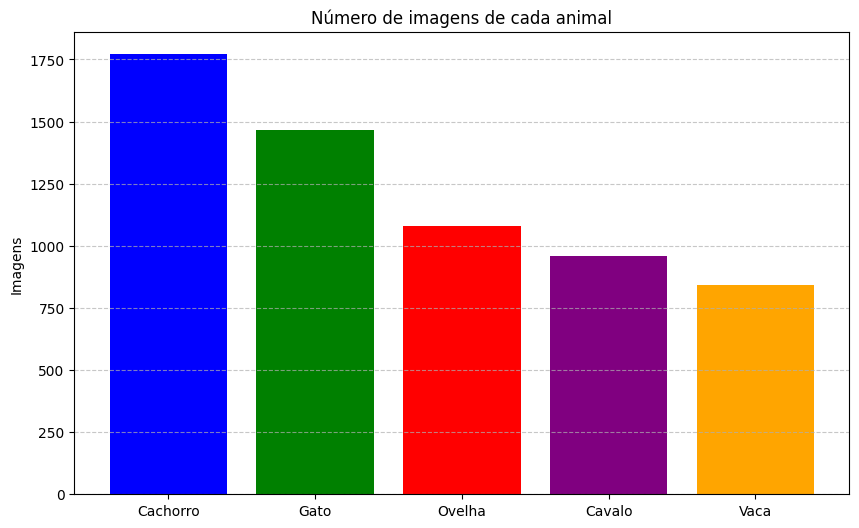

In [43]:
animal_counts = {
    'Cachorro': num_dogs,
    'Gato': num_cats,
    'Ovelha': num_sheep,
    'Cavalo': num_horses,
    'Vaca': num_cows
}

plt.figure(figsize=(10, 6))
plt.bar(animal_counts.keys(), animal_counts.values(), color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('Imagens')
plt.title('Número de imagens de cada animal')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [44]:
# Número total de imagens de bovinos
print(f"Total de imagens de bovinos: {num_cows}")

Total de imagens de bovinos: 842


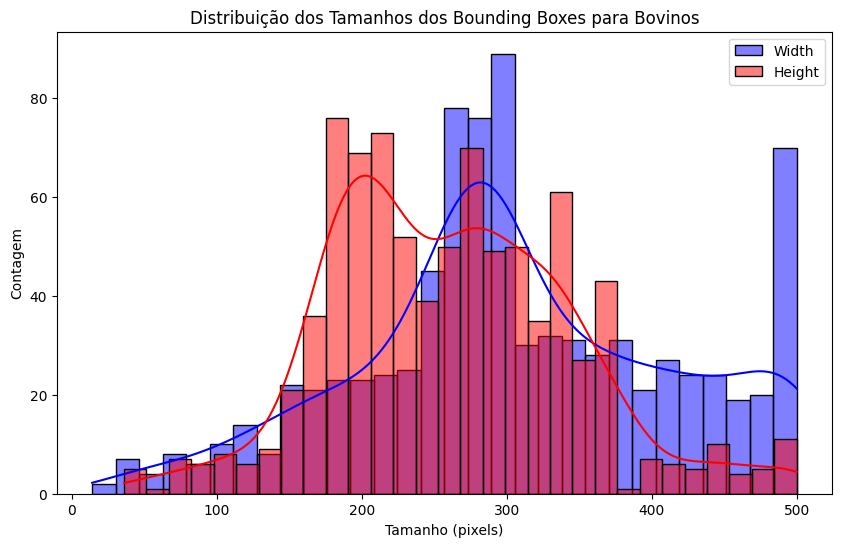

In [45]:
cow_annotations = [ann for ann in JSON['annotations'] if ann['category_id'] == 5]
keypoints_count = [ann['num_keypoints'] for ann in cow_annotations]
bbox_sizes = [(ann['bbox'][2], ann['bbox'][3]) for ann in cow_annotations]

df_keypoints = pd.DataFrame(keypoints_count, columns=['Keypoints'])
df_bboxes = pd.DataFrame(bbox_sizes, columns=['Width', 'Height'])

plt.figure(figsize=(10, 6))
sns.histplot(df_bboxes['Width'], bins=30, kde=True, color='blue', label='Width')
sns.histplot(df_bboxes['Height'], bins=30, kde=True, color='red', label='Height')
plt.title('Distribuição dos Tamanhos dos Bounding Boxes para Bovinos')
plt.xlabel('Tamanho (pixels)')
plt.ylabel('Contagem')
plt.legend()
plt.show()